<a href="https://www.kaggle.com/code/zjzhao1002/poisonous-mushroom-classification?scriptVersionId=194244207" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Basic Information of Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
print(df_train.head())

   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       

In [3]:
df_train.columns

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [4]:
df_train.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [5]:
df_train.shape

(3116945, 22)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

# 2. Data Cleaning

We have seen that there are many missing values in the data, so we have to clean data before training our model.

In [7]:
num_columns = df_train.select_dtypes(include='float64').columns
cat_columns = df_train.select_dtypes(include='object').columns

For the numeric columns, we impute the median of corresponding column. 

In [8]:
for column in num_columns:
    df_train[column] = df_train[column].fillna(float(df_train[column].median()))

For the catagorical columns, we have seen some columns have too many missing values. If a column has missing values more than 60% of total, we may say that this column can be removed safely. 

In [9]:
nan_count = df_train.isna().sum()
total_count = df_train.shape[0]
nan_ratio = nan_count / total_count
high_nan_ratio = nan_ratio[nan_ratio > 0.6]
print(high_nan_ratio)

stem-root            0.884527
stem-surface         0.635514
veil-type            0.948843
veil-color           0.879370
spore-print-color    0.914255
dtype: float64


In [10]:
df_train_new = df_train.drop(['id', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'], axis=1)

We fill 'none' to the remained columns.

In [11]:
cat_columns = df_train_new.select_dtypes(include='object').columns

for column in cat_columns:
    df_train_new[column].fillna('none', inplace=True)

/tmp/ipykernel_36/2479688860.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_new[column].fillna('none', inplace=True)


Now we can check if there is any missing value in our data.

In [12]:
print(df_train_new.isna().sum())

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


Now we look into the unique values in catagorical columns.

In [13]:
df_train_new[cat_columns].nunique()

class                    2
cap-shape               75
cap-surface             84
cap-color               79
does-bruise-or-bleed    27
gill-attachment         79
gill-spacing            49
gill-color              64
stem-color              60
has-ring                24
ring-type               41
habitat                 53
season                   4
dtype: int64

Obviously, thera are too many values in these columns except the 'class' and 'season' columns. We want to collect the values that appear less frequently, and treat them as 'noise'.

In [14]:
def remove_noise(df):
    cat_columns = df.select_dtypes(include='object').columns
    for column in cat_columns:
        count = df[column].value_counts()
        less_freq = count[count<101].index
        df[column] = df[column].apply(lambda x: 'noise' if x in less_freq else x)
    return df

In [15]:
df_train_new = remove_noise(df_train_new)

In [16]:
df_train_new[cat_columns].nunique()

class                    2
cap-shape                8
cap-surface             13
cap-color               13
does-bruise-or-bleed     3
gill-attachment          9
gill-spacing             5
gill-color              13
stem-color              14
has-ring                 3
ring-type               10
habitat                  9
season                   4
dtype: int64

It seems much better now. We make some plots to see the distributions.

In [17]:
def make_barplot(df):
    cat_columns = df.select_dtypes(include='object').columns
    for column in cat_columns:
        plt.figure(figsize=(10, 5))
        uni_count = df[column].value_counts()
        sns.barplot(x=uni_count.index, y=uni_count.values)
        plt.ylabel(f"Count of '{column}'")
        plt.xlabel(f"{column}")
        plt.title(f"Count of unique categories in column '{column}'")
        plt.show()

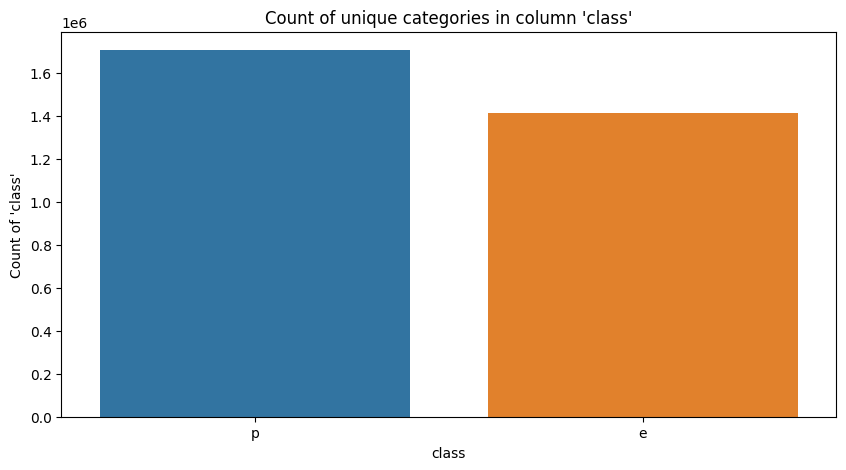

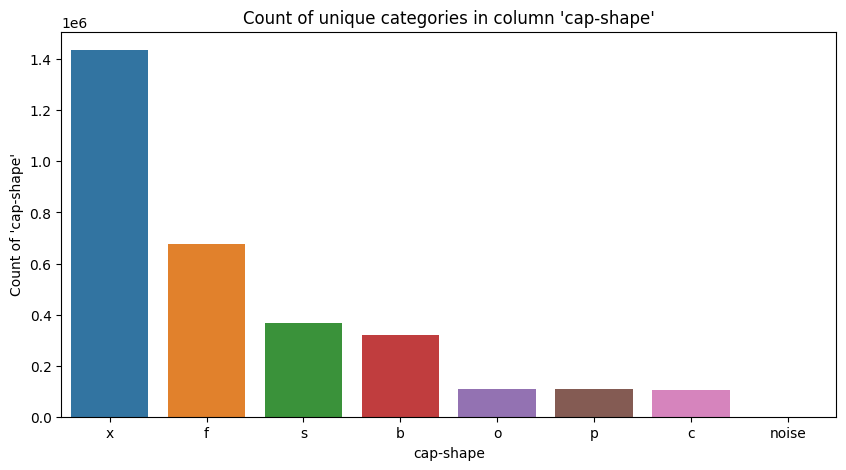

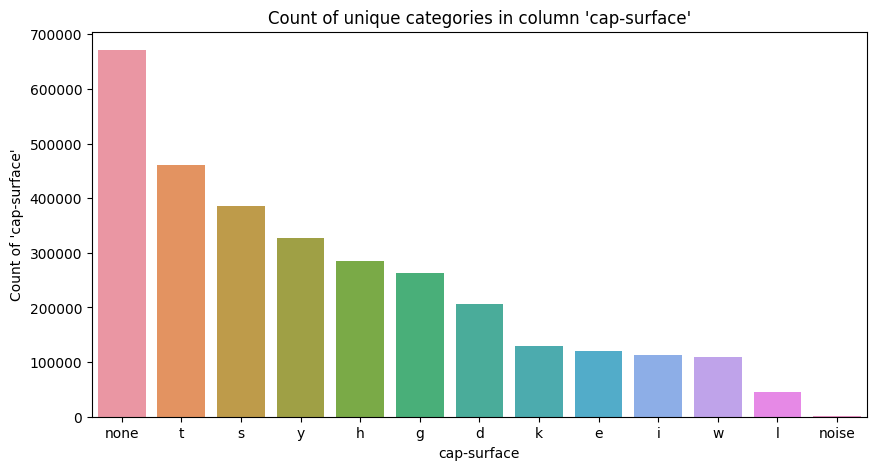

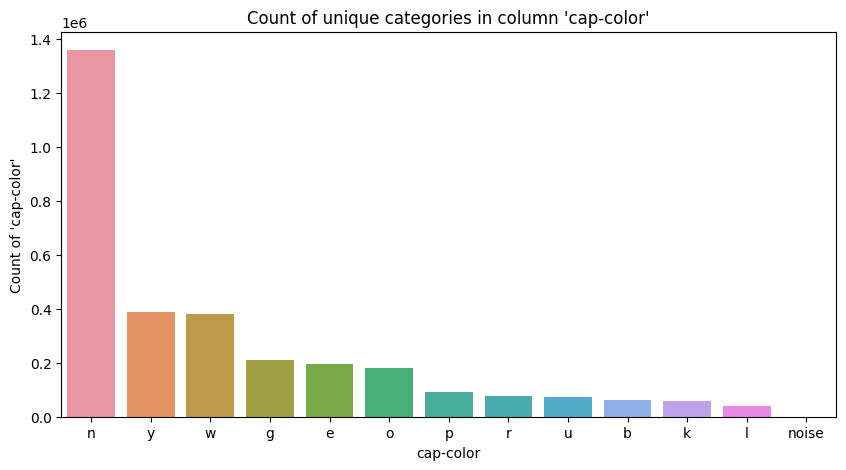

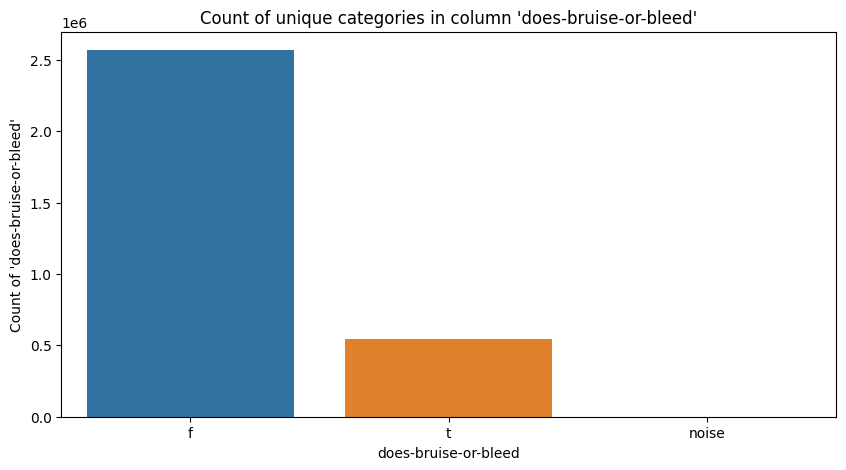

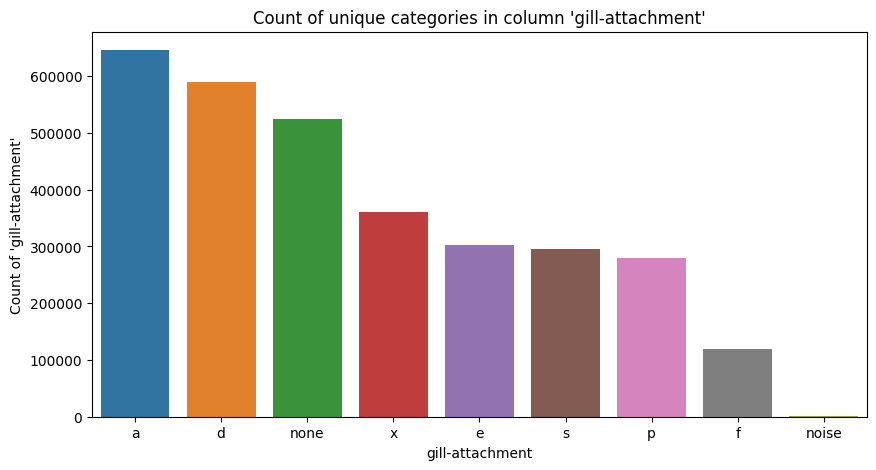

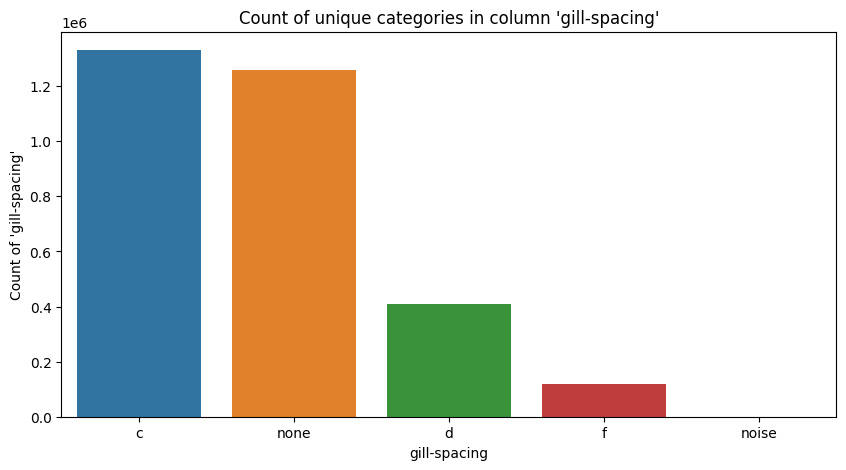

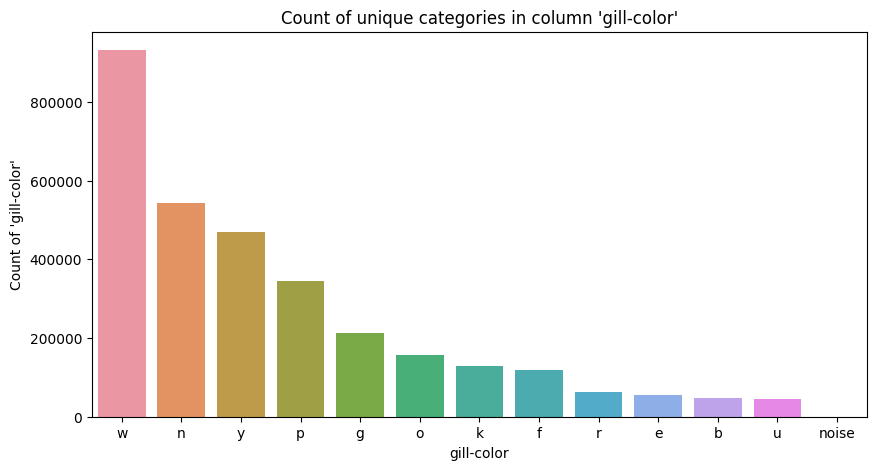

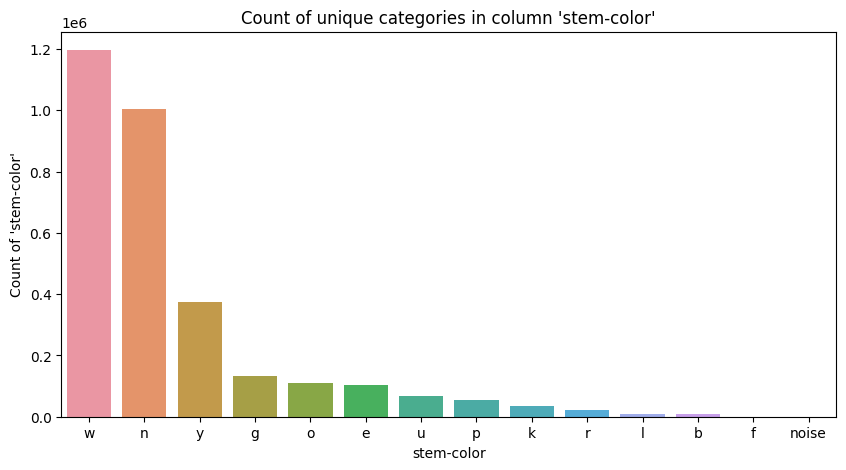

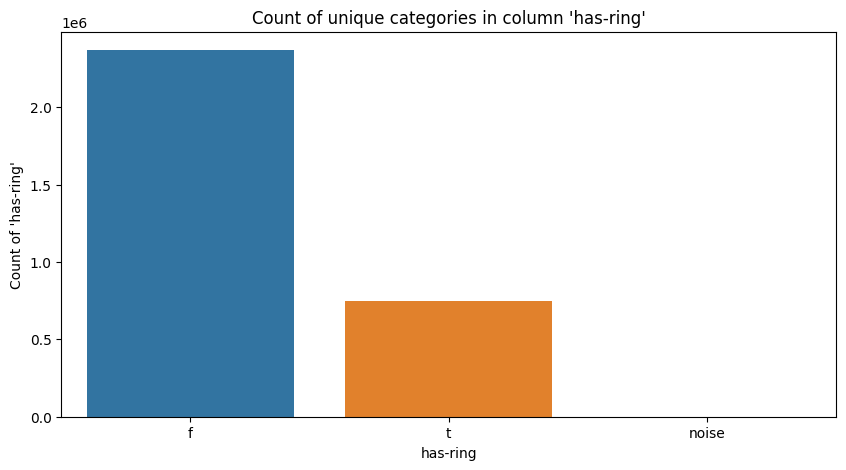

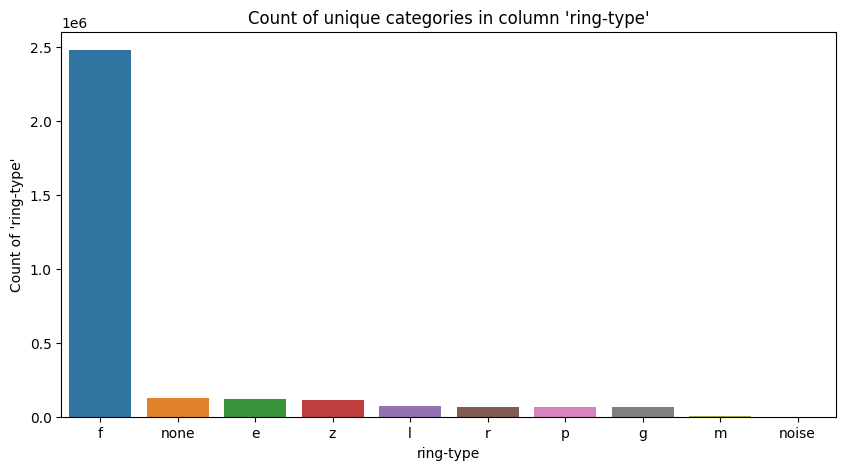

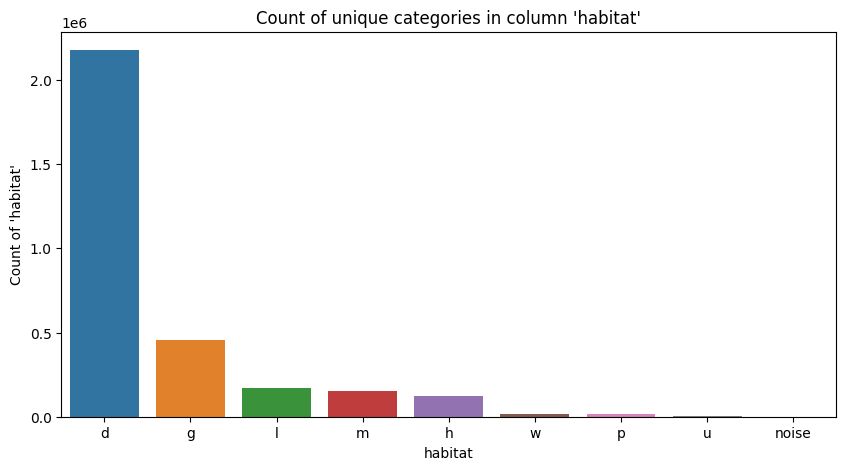

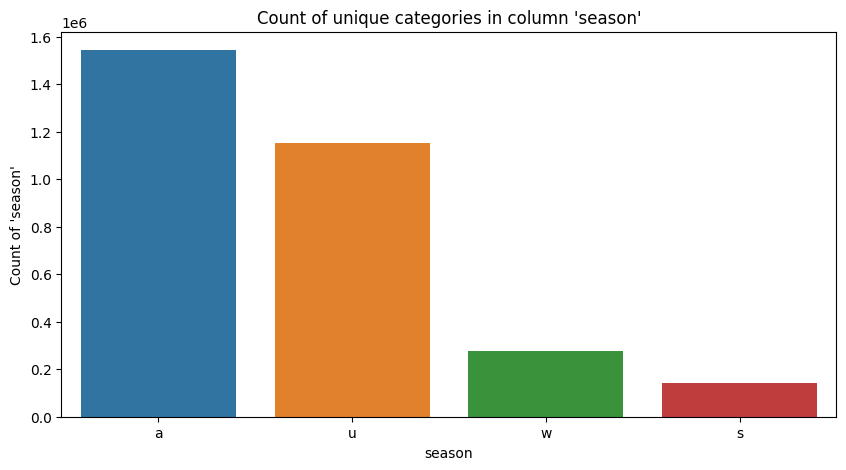

In [18]:
make_barplot(df_train_new)

We can see that most columns have replaced the 'none' by the 'noise'. However, we also see that the 'none' is the largest fraction of the 'cap-surface' column. This may introduce some uncertainties. 

We can also look at the distributions of the numeric columns:

In [19]:
def make_hist(df):
    num_columns = df.select_dtypes(include='float64').columns
    for column in num_columns:
        pvalue = df[df['class']=='p'][column].to_numpy()
        evalue = df[df['class']=='e'][column].to_numpy()
        fig, ax = plt.subplots(figsize=(10,5))
        ax.hist(pvalue, bins=30, range=[0, 60], density=True, label='p')
        ax.hist(evalue, bins=30, range=[0, 60], density=True, label='e')
        ax.legend()
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Fraction of data')
        plt.show()

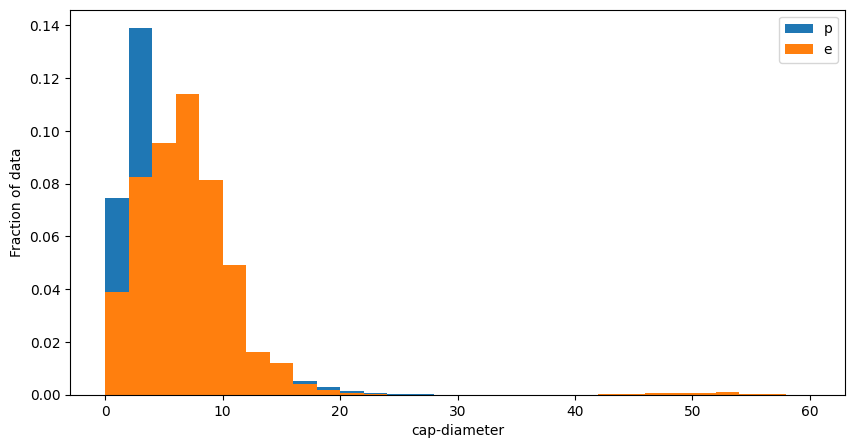

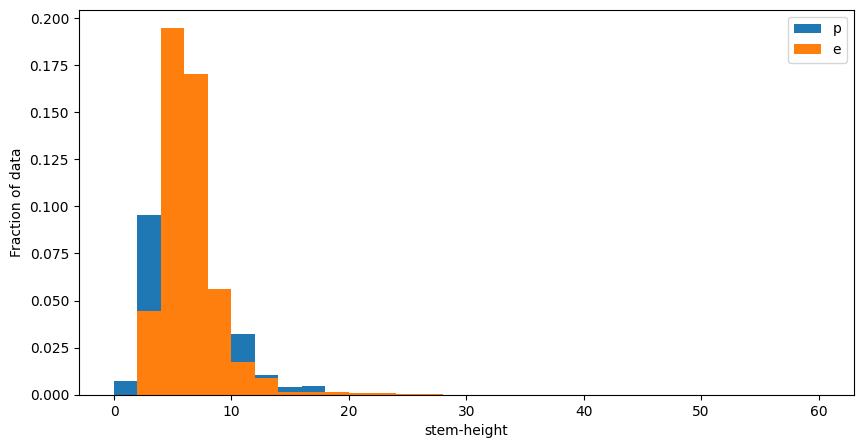

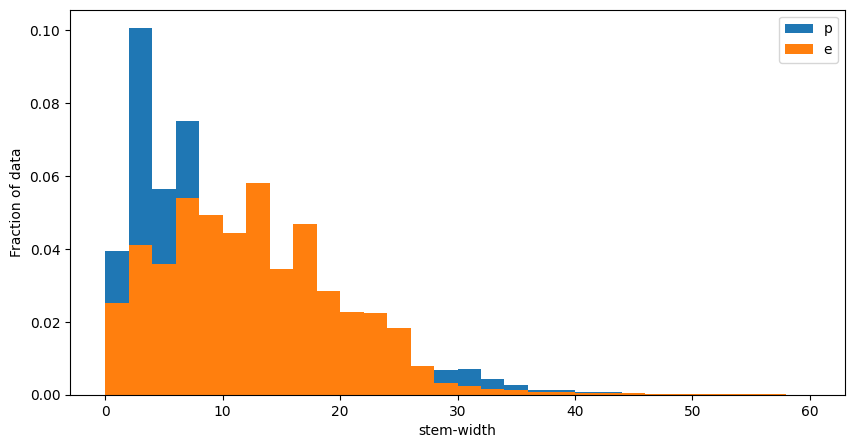

In [20]:
make_hist(df_train_new)

It seems that the poisonous mushrooms tend to have smaller cap-diameter and stem-width than the editable mushrooms.

# 3. Encoding

The next step is encoding the data for training. 

In [21]:
X_train = df_train_new.drop(['class'], axis=1)
y_train = df_train_new['class']

We scale the numeric data by the StandardScaler and encode the catagorical data by the OrdinalEncoder. 

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

def preprocess(df):
    cat_columns = df.select_dtypes(include='object').columns
    num_columns = df.select_dtypes(include='float64').columns
    
    scaler = StandardScaler()
    df[num_columns] = scaler.fit_transform(df[num_columns])
    
    encoder = OrdinalEncoder()
    df[cat_columns] = encoder.fit_transform(df[cat_columns].astype(str))
    
    return df

In [23]:
X_train = preprocess(X_train)

In [24]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train

array([0, 1, 0, ..., 1, 0, 1])

# 4. Model

In [25]:
from sklearn.model_selection import train_test_split

X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.20,
    random_state=1
)

We use the XGBoost model in this case.

In [26]:
from xgboost import XGBClassifier

model = XGBClassifier(
    gamma = 0.01,
    min_child_weight=1,
    subsample = 0.8, 
    colsample_bytree = 0.7,
    reg_alpha = 0.5,
    reg_lambda = 1.0, 
    learning_rate = 0.01,
    n_estimators = 2000, 
    max_depth = 10,
    random_state = 1,
    early_stopping_rounds = 10,
    device = "cuda"
)

In [27]:
history = model.fit(
    X_train_new, 
    y_train_new,
    eval_set = [(X_val, y_val)],
    verbose = True
)

[0]	validation_0-logloss:0.68179
[1]	validation_0-logloss:0.67574
[2]	validation_0-logloss:0.66971
[3]	validation_0-logloss:0.66311
[4]	validation_0-logloss:0.65600
[5]	validation_0-logloss:0.65017
[6]	validation_0-logloss:0.64313
[7]	validation_0-logloss:0.63682
[8]	validation_0-logloss:0.63133
[9]	validation_0-logloss:0.62591
[10]	validation_0-logloss:0.61956
[11]	validation_0-logloss:0.61318
[12]	validation_0-logloss:0.60757
[13]	validation_0-logloss:0.60279
[14]	validation_0-logloss:0.59708
[15]	validation_0-logloss:0.59202
[16]	validation_0-logloss:0.58715
[17]	validation_0-logloss:0.58162
[18]	validation_0-logloss:0.57607
[19]	validation_0-logloss:0.57200
[20]	validation_0-logloss:0.56660
[21]	validation_0-logloss:0.56250
[22]	validation_0-logloss:0.55792
[23]	validation_0-logloss:0.55248
[24]	validation_0-logloss:0.54737
[25]	validation_0-logloss:0.54267
[26]	validation_0-logloss:0.53736
[27]	validation_0-logloss:0.53217
[28]	validation_0-logloss:0.52745
[29]	validation_0-loglos

In [28]:
from sklearn.metrics import matthews_corrcoef

y_pred = history.predict(X_val)
mcc = matthews_corrcoef(y_val, y_pred)
print(mcc)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:04:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.9829469638664341


# 5. Prediction

We do the same things to the test data and make predictions.

In [29]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
num_columns = df_test.select_dtypes(include='float64').columns
cat_columns = df_test.select_dtypes(include='object').columns

for column in num_columns:
    df_test[column] = df_test[column].fillna(float(df_test[column].median()))

df_test_new = df_test.drop(['id', 'stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'], axis=1)

cat_columns = df_test_new.select_dtypes(include='object').columns

for column in cat_columns:
    df_test_new[column].fillna('none', inplace=True)

df_test_new = remove_noise(df_test_new)
X_test = df_test_new
X_test = preprocess(X_test)
X_test.head()

/tmp/ipykernel_36/3127810417.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test_new[column].fillna('none', inplace=True)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0.498097,7.0,8.0,5.0,2.0,5.0,4.0,11.0,1.772335,0.737221,12.0,2.0,2.0,0.0,0.0
1,0.126735,4.0,10.0,7.0,0.0,5.0,0.0,12.0,-1.880901,-0.049181,6.0,0.0,1.0,0.0,0.0
2,-0.919055,0.0,2.0,5.0,0.0,5.0,0.0,5.0,-0.061693,-0.988666,6.0,0.0,1.0,0.0,1.0
3,-0.605318,7.0,10.0,5.0,0.0,7.0,0.0,5.0,-0.506306,-0.325718,12.0,2.0,9.0,0.0,2.0
4,-0.029067,7.0,3.0,12.0,0.0,6.0,4.0,12.0,0.142088,0.315009,13.0,2.0,6.0,0.0,2.0


Finally, we generate the file for submission.

In [30]:
results = history.predict(X_test)
submission = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
submission['class'] = results
submission['class'] = submission['class'].replace({1: 'p', 0: 'e'})
submission.to_csv('submission.csv', index=False)

In [31]:
submission.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
